In [3]:
import os
import sys
from copy import deepcopy

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
# from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [4]:
# Dataset
object_labels = [13]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('val',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 002_PKA!



4311it [00:02, 1872.18it/s]


Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Loading the take 007_TKA!



3466it [00:01, 1932.52it/s]


Loading the take 009_TKA!



3276it [00:02, 1594.76it/s]

Interpolated frames are not included! The number of frames in the cameras are not equal!
Last frame assertion failed due to exclusion of the interpolated frames!
Lenght of the dataset! 14642


In [5]:
# Sanity check for the dataset
# for jj in range(len(test_dataset)):
#     assert test_dataset.images[jj] != []
#     assert test_dataset.segmentation_masks[jj] != []

In [6]:
# import re
# for idx, im in enumerate(test_dataset.images):
#     if re.search('camera04', str(im[0])):
#         print(f'Found {idx}: {im[0]}')
#         break
# test_dataset.images[0], test_dataset.images[idx-1], test_dataset.images[idx], test_dataset.images[2*idx-1], test_dataset.images[2*idx]

In [7]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)
# 035 idx 2761 has a problem!
# Image
len_objects = len(object_labels)
toPILimage = ToPILImage()
exist = False
exist_idx = []
idx = 0

for idx in tqdm(range(len(test_dataset))):
    if len(exist_idx) == 3:
        break
    # idx = 25424
    # print(f'Index: {idx}')
    frame_obj_list, frames_segmentation_mask = test_dataset[idx]
    image = frame_obj_list.frames[0].data
    # print('Input Image:')
    # toPILimage(revert_transform(image)).show()
    for j in range(len_objects):
        exist = torch.any(frame_obj_list.frames[0].objects[j].segment == True)
        if exist:
            exist_idx.append(idx)
            break

  8%|▊         | 1099/14642 [01:05<13:23, 16.85it/s]


In [8]:
exist_idx
# Obj: 0
# 1623 - 1632
# 2561 - 2931

# Obj: 13
# 3172 - 3216
# 4804 - 4905

# Obj: 15
# 4442 - 4455
# 4474 - 4484
# 4716 - 4722
# 4732 - 4741

# Obj 13 (train)
# 4394

[1095, 1096, 1098]

In [9]:
import json

with open('../temp/train_13_15.json', 'w') as f:
    json.dump({'train_13_15': exist_idx}, f)

In [10]:
len_data = len(test_dataset)
print(f'Length of the dataset: {len_data}')
camera_switch = (len_data//3, 2*len_data//3)
print(test_dataset.images[0], '\n', test_dataset.images[camera_switch[0]-1], '\n', test_dataset.images[camera_switch[0]])

Length of the dataset: 14642
[PosixPath('/home/polyaxon-data/data1/MM-OR_processed/002_PKA/colorimage/camera01_colorimage-000321.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera04_colorimage-000955.jpg')] 
 [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera05_colorimage-000955.jpg')]


In [11]:
iid = exist_idx[-1]
cam1 = test_dataset.images[iid]
cam4 = test_dataset.images[iid + len_data//3]
cam5 = test_dataset.images[iid + 2*len_data//3]

# Use get item: 0) VideoDataBatch 1) Segmentation mask
cam1_vid = test_dataset[iid][0]
cam4_vid = test_dataset[iid + len_data//3][0]
cam5_vid = test_dataset[iid + 2*len_data//3][0]

# Use first frame
cam1 = cam1_vid.frames[0].data
cam4 = cam4_vid.frames[0].data
cam5 = cam5_vid.frames[0].data

gt_mask1 = cam1_vid.frames[0].objects[0].segment
gt_mask4 = cam4_vid.frames[0].objects[0].segment
gt_mask5 = cam5_vid.frames[0].objects[0].segment

print(gt_mask1.shape)
print(gt_mask1.dtype)

torch.Size([512, 512])
torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


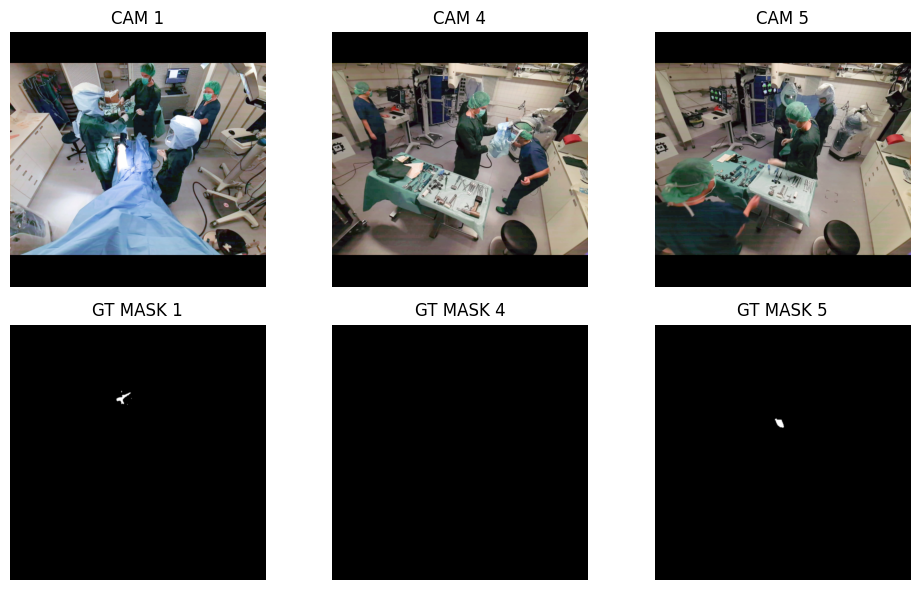

In [12]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Transpose from tensor to numpy shape
cam1 = revert_transform(cam1).permute(1,2,0)
cam4 = revert_transform(cam4).permute(1,2,0)
cam5 = revert_transform(cam5).permute(1,2,0)

# First row (RGB, GT, Black Placeholder)
axes[0,0].imshow(cam1)
axes[0,0].set_title("CAM 1")

axes[0,1].imshow(cam4)
axes[0,1].set_title("CAM 4")

axes[0,2].imshow(cam5)
axes[0,2].set_title("CAM 5")

axes[1,0].imshow(gt_mask1, cmap='gray')
axes[1,0].set_title("GT MASK 1")

axes[1,1].imshow(gt_mask4, cmap='gray')
axes[1,1].set_title("GT MASK 4")

axes[1,2].imshow(gt_mask5, cmap='gray')
axes[1,2].set_title("GT MASK 5")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()